In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [1]:
seed = 0
trace_filename = 'day-1'
feed_async = True
feed_async_granularity = 1
scaling_level = 1 # 0 for off, 1 for spot, 2 for inter model scaling
scaling_interval = 15 # -1 for off, otherwise +ve values in seconds
lts = False
sts = True

def get_output_dir(seed=seed, trace_filename=trace_filename, feed_async=feed_async,
                   feed_async_granularity=feed_async_granularity, scaling_level=scaling_level,
                   scaling_interval=scaling_interval, lts=lts, sts=sts):
    # output_dir = f'../results/{seed}/{trace_filename}/feed_async_{feed_async}/feed_async_granularity_{feed_async_granularity}/scaling_level_{scaling_level}/scaling_interval_{scaling_interval}/lts_{lts}_sts{sts}'    
    output_dir = f'../results/2024_12_9/2_47_46/'
    assert os.path.isdir(output_dir), f"Directory {output_dir} does not exist"
    return output_dir

In [4]:
def get_merged_df(dir_path, sort_by='timestamp'):
    filenames = os.listdir(dir_path)
    frames = [pd.read_csv(os.path.join(dir_path, filenames.pop()))]
    for filename in filenames:
        filepath = os.path.join(dir_path, filename)
        frames.append(pd.read_csv(filepath))
    df = pd.concat(frames).sort_values(by=sort_by).reset_index()
    return df

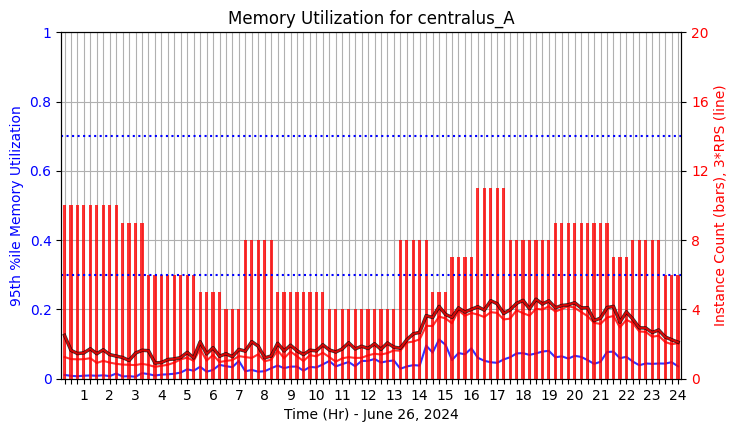

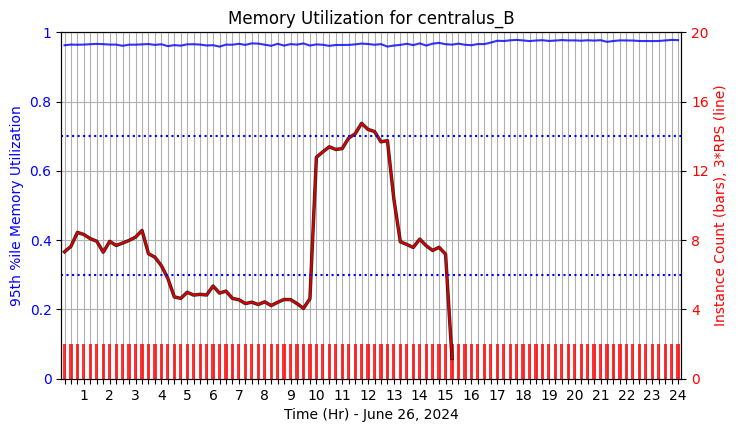

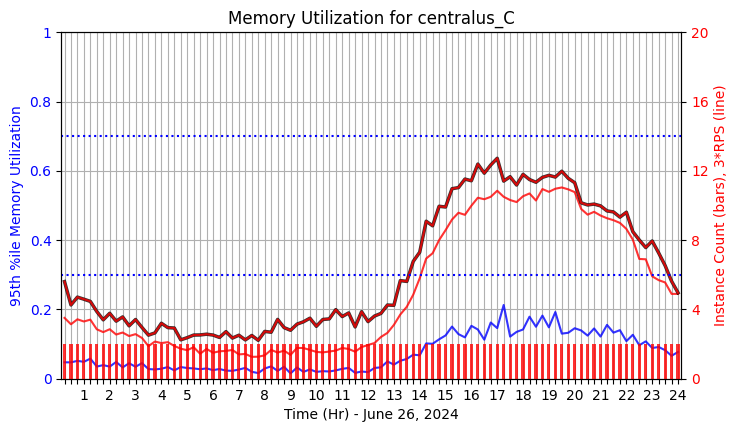

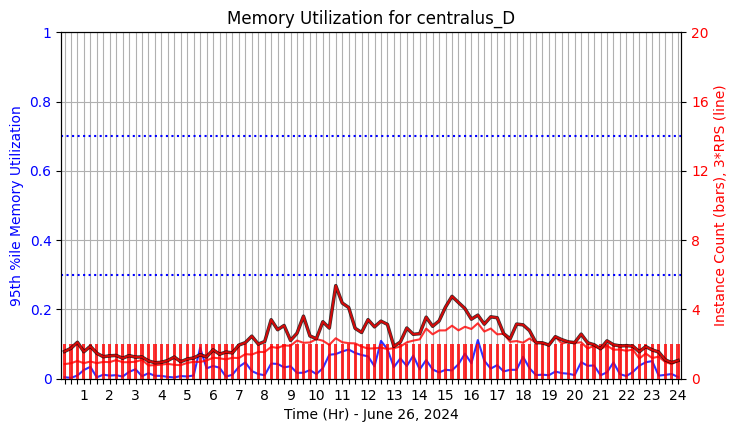

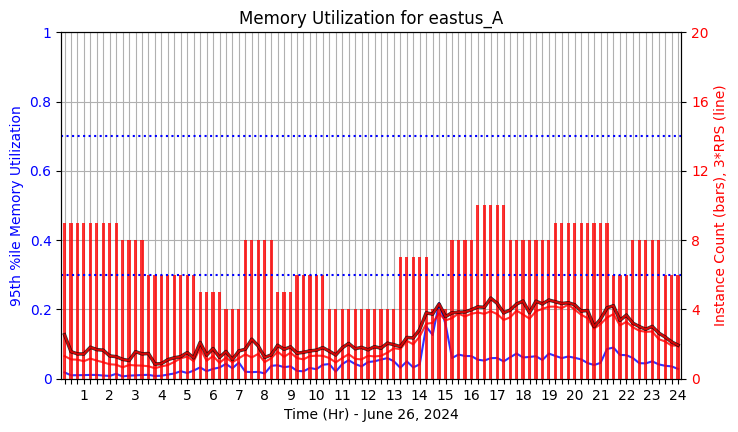

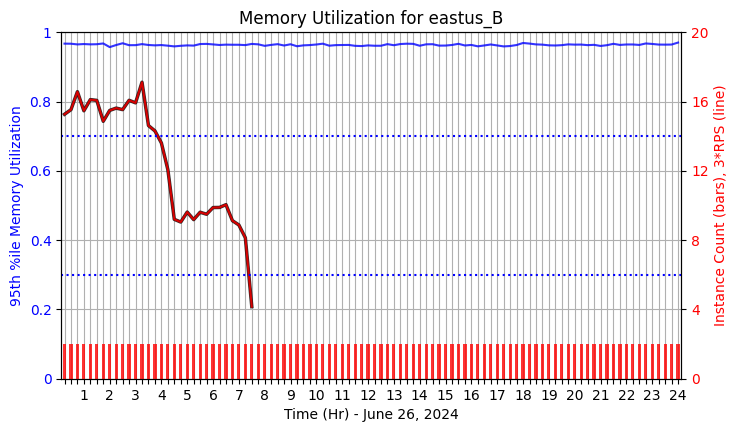

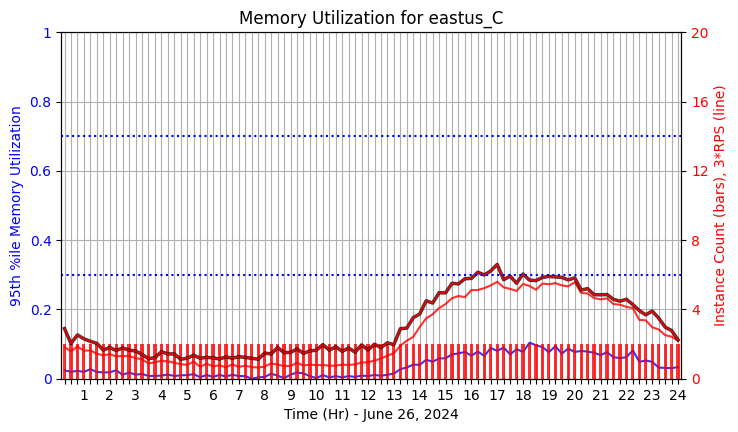

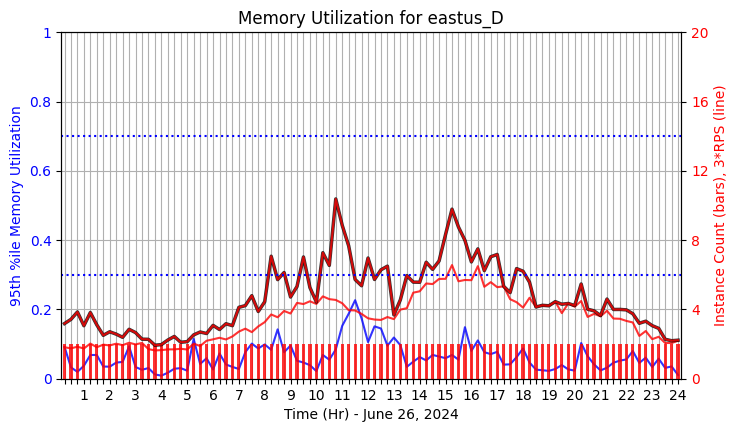

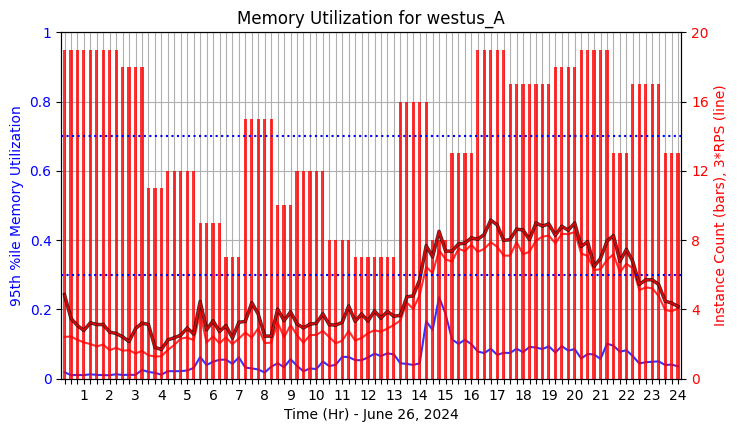

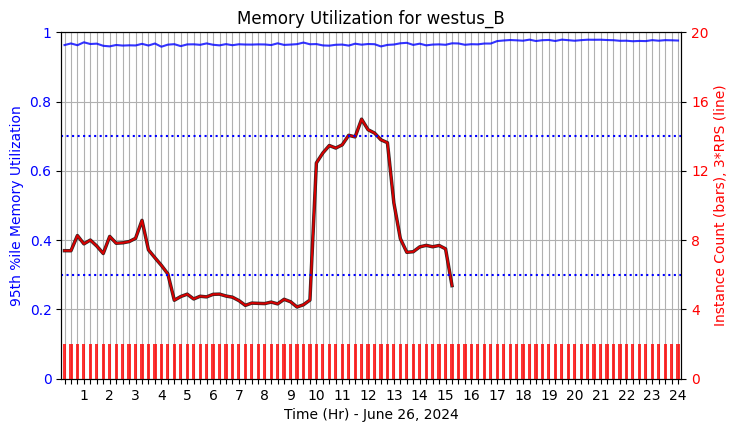

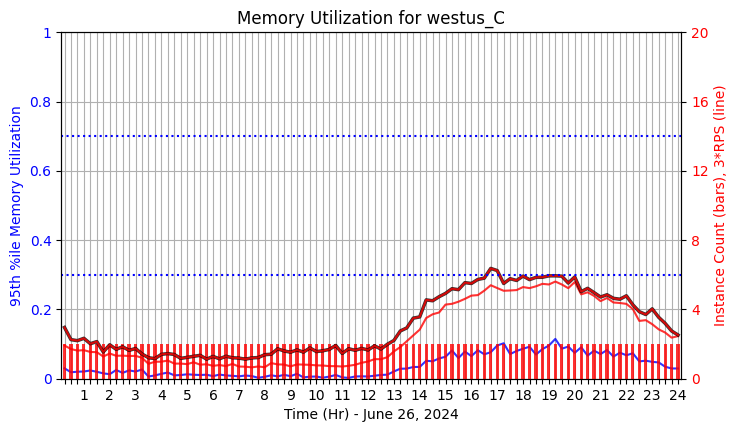

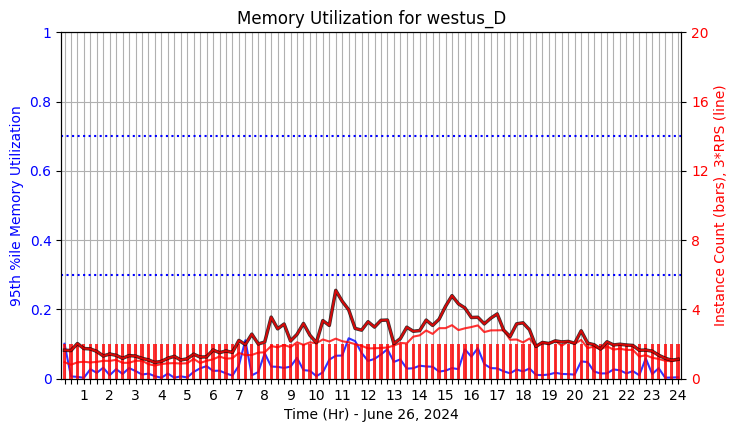

In [5]:
# memory state

memory_df = get_merged_df(os.path.join(get_output_dir(), 'memory'), sort_by='time')
memory_df = memory_df[memory_df['time'] <= 86400].copy()
memory_df['region_model'] = memory_df['instance'].apply(lambda name: name[:name.index('_', name.index('_')+1)])
memory_df['util'] = memory_df['memory']/memory_df['max_memory']
import matplotlib.pyplot as plt
for data in [memory_df]:
    for region_model in sorted(list(set(data['region_model'].unique()))):
        region = region_model[:region_model.index('_')]
        model = region_model[region_model.index('_')+1:]
        # region_router_file = f"/Users/shashwat/capalloc/results/0/ES_26/{feed_async}/region_routers/{region}"
        # rrdf = get_merged_df(region_router_file, sort_by='arrival_timestamp')
        rrdf = get_merged_df(os.path.join(get_output_dir(), f'region_routers/{region}'), sort_by='arrival_timestamp')
        rrdf = rrdf[rrdf['arrival_timestamp'] <= 86400].copy()
        rrdf = rrdf[rrdf['model'] == model]
        rrdf_agg = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg.loc[:, 'time_bucket'] = pd.cut(rrdf_agg['arrival_timestamp'], bins=range(0, int(rrdf_agg['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg = rrdf_agg.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg['time_midpoint'] = rrdf_agg['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg['model'] = rrdf_agg['model'] / 300

        # prod only
        rrdf = rrdf[rrdf['workload_type'] == 'prod']
        rrdf_agg_prod = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg_prod.loc[:, 'time_bucket'] = pd.cut(rrdf_agg_prod['arrival_timestamp'], bins=range(0, int(rrdf_agg_prod['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg_prod = rrdf_agg_prod.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg_prod['time_midpoint'] = rrdf_agg_prod['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg_prod['model'] = rrdf_agg_prod['model'] / 300

        plt.figure(figsize=(8, 4.5), dpi=100)
        ax = plt.gca()
        d1 = data[data['region_model'] == region_model].copy()
        d1_agg = d1.groupby('time', observed=False).agg({'util': 'max', 'instance': lambda x: len(set(x)), 'memory': sum , 'max_memory': sum}).reset_index()
        d1_agg['util'] = d1_agg['memory'] / d1_agg['max_memory']
        
        # print(d1_agg)
        # break
        # d1_agg.columns = ['time_bucket', 'max_util', 'count']
        d1_agg.loc[:, 'time_bucket'] = pd.cut(d1_agg['time'], bins=range(0, int(d1_agg['time'].max()) + 900, 900), right=False)
        
        # print(d1)
        d1_agg = d1_agg.groupby('time_bucket', observed=False).agg({'util': lambda x: x.quantile(0.5), 'instance': 'max'}).reset_index()
        # d1_agg = d1_agg.merge(r, on='time_bucket', how='inner')
        
        # d1_agg = d1.groupby('time_bucket', observed=False)['util'].quantile(0.9).reset_index()
        d1_agg['time_midpoint'] = d1_agg['time_bucket'].apply(lambda x: x.mid)
        # print(d1_agg)

        ax2 = ax.twinx()
        d1_agg.plot(x='time_midpoint', y='instance', kind='bar', ax=ax2, color='red', alpha=0.8)
        ax2.set_ylabel('Instance Count (bars), 3*RPS (line)', color='red')
        # d1_agg.plot(x='time_midpoint', y='request_id', kind='line', ax=ax2, color='green', alpha=0.8)
        ax2.set_ylim(0, 20)
        ax2.set_yticks(range(0, 21, 4))
        ax2.set_yticklabels(range(0, 21, 4), color='red')

        # print(rrdf_agg_prod)
        # rrdf_agg_prod.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='black', linewidth=2, alpha=0.8)
        rrdf_agg_prod.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='red', linewidth=1.5, alpha=0.8)

        # print(rrdf_agg)
        rrdf_agg.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='black', linewidth=2.5, alpha=0.8)
        rrdf_agg.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='red', linewidth=1.5, alpha=0.8)
        # ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=0, y2=rrdf_agg_prod['model'], color='red', alpha=1)
        # ax2.legend(loc='upper right')

        d1_agg.plot(x='time_midpoint', y='util', kind='line', ax=ax, color='blue', alpha=0.8)
        # ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=0, y2=1, color='red', alpha=1)
        # plt.legend()
        ax2.legend().set_visible(False)
        ax.legend().set_visible(False)
        plt.title(f'Memory Utilization for {region_model}')
        # plt.axhline(y=16, color='red', linestyle='dotted')
        plt.axhline(y=20*0.7, color='blue', linestyle='dotted')
        plt.axhline(y=20*0.3, color='blue', linestyle='dotted')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_ylabel('95th %ile Memory Utilization', color='blue')
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], color='blue')
        ax.set_xlabel('Time (Hr) - June 26, 2024')
        # ax.set_xticks(range(1, 25))
        # ax.set_xticklabels(range(1, 25))
        # ax.set_xticks(range(0, 25, 2))
        # ax.set_xlim(0, 96)
        ax.set_xticklabels(['' if i % 4 !=3 else i//4 + 1 for i in range(0, int(d1_agg['time_midpoint'].max()//900)+1)])
        ax.grid(True)
        plt.show()
# plt.scatter(df['time'], df['util'])
# plt.xlabel('Time')
# plt.ylabel('Util')
# plt.title('Scatter Plot of Util vs Time')
# plt.show()

In [17]:
memory_df[memory_df['region_model'] == 'westus_D']['util'].quantile([0.8, 0.9, 1.0])

0.8    0.090493
0.9    0.134168
1.0    0.416169
Name: util, dtype: float64

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

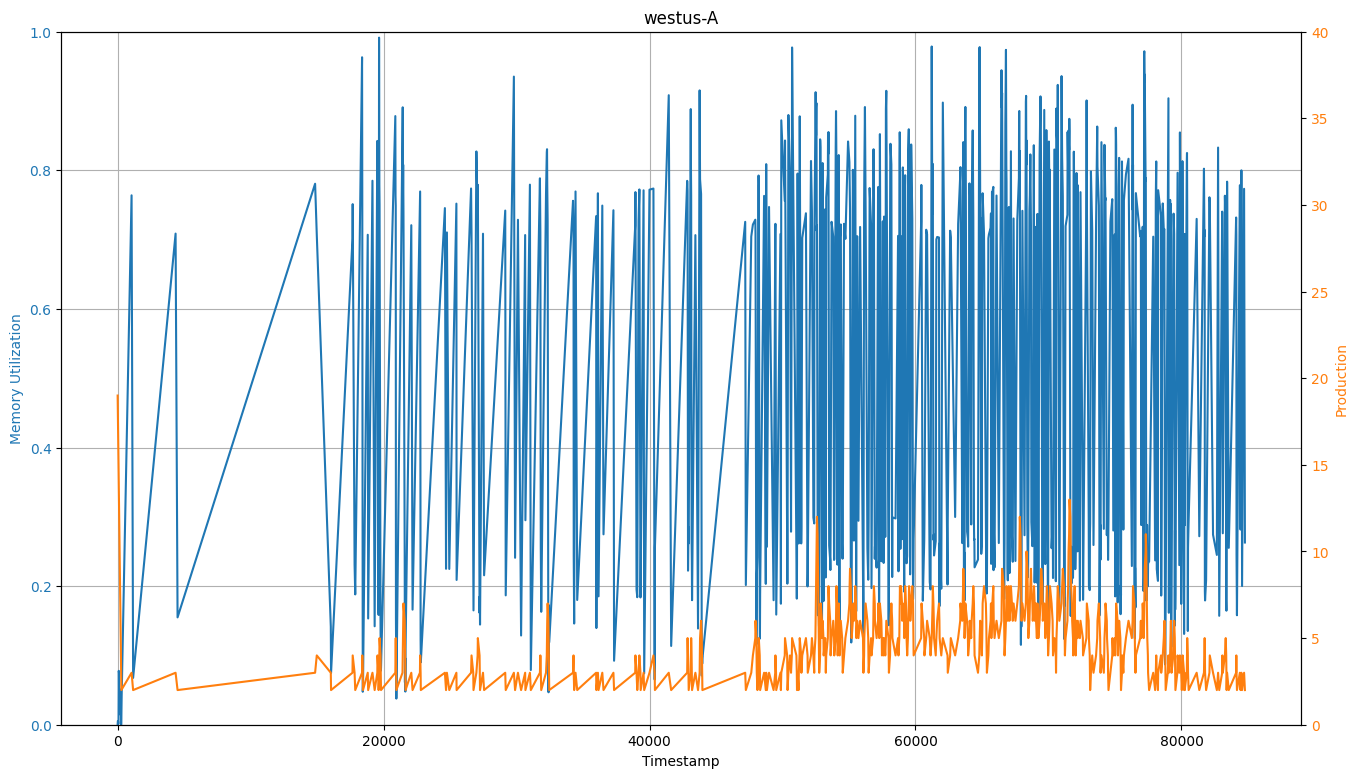

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

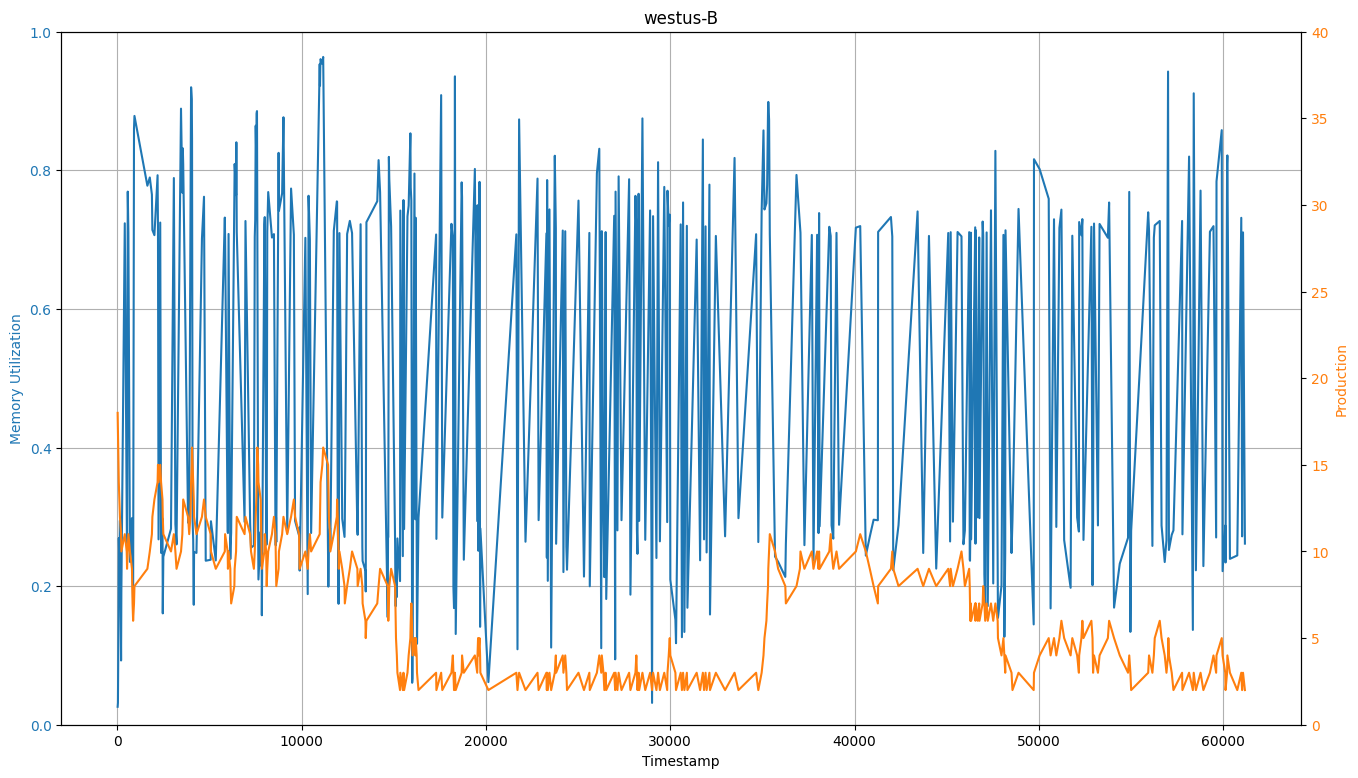

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

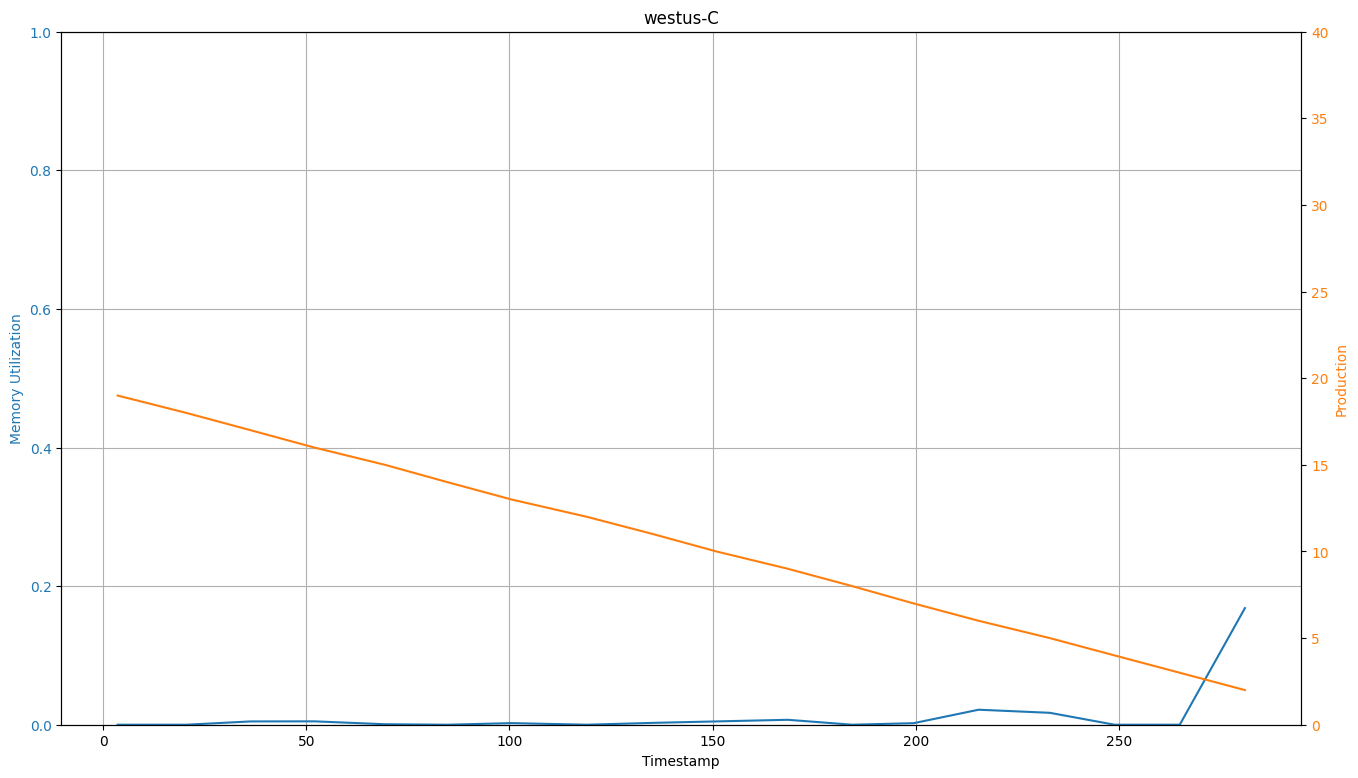

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

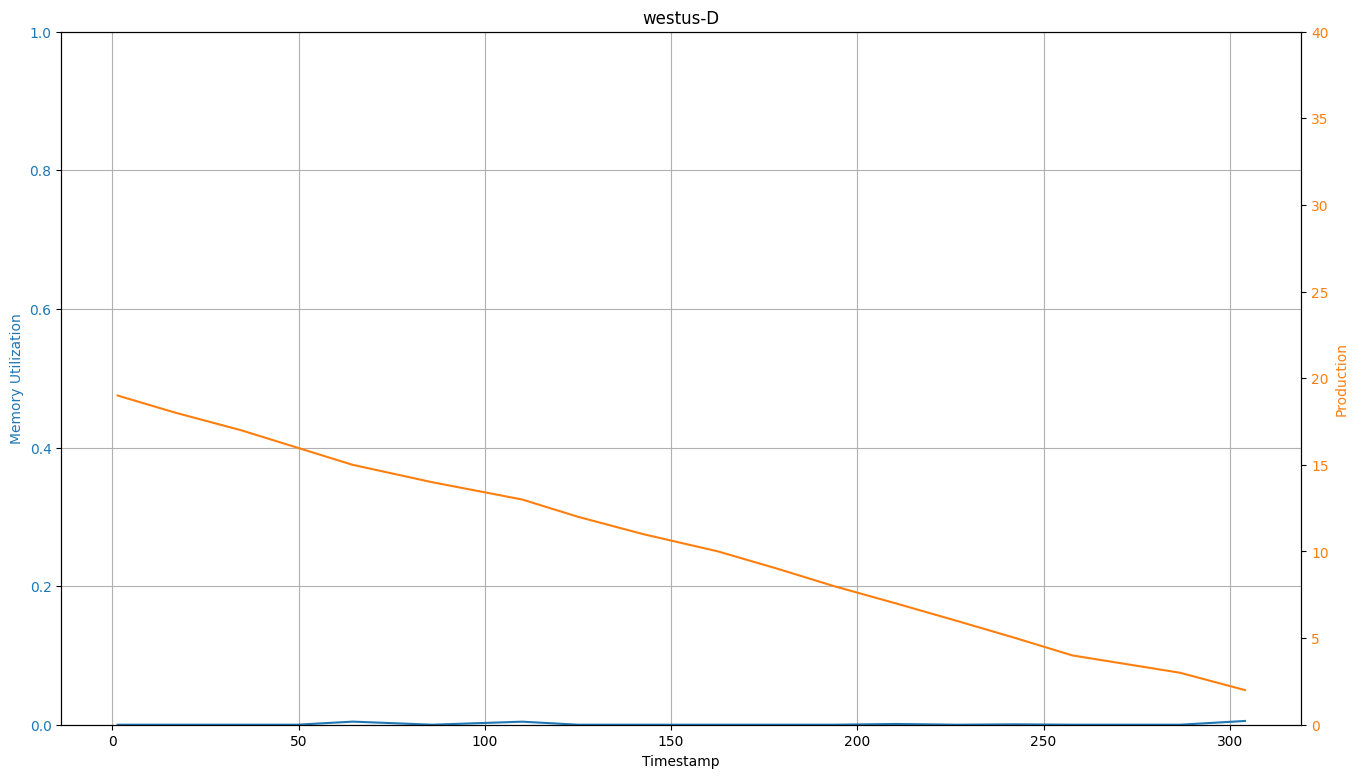

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

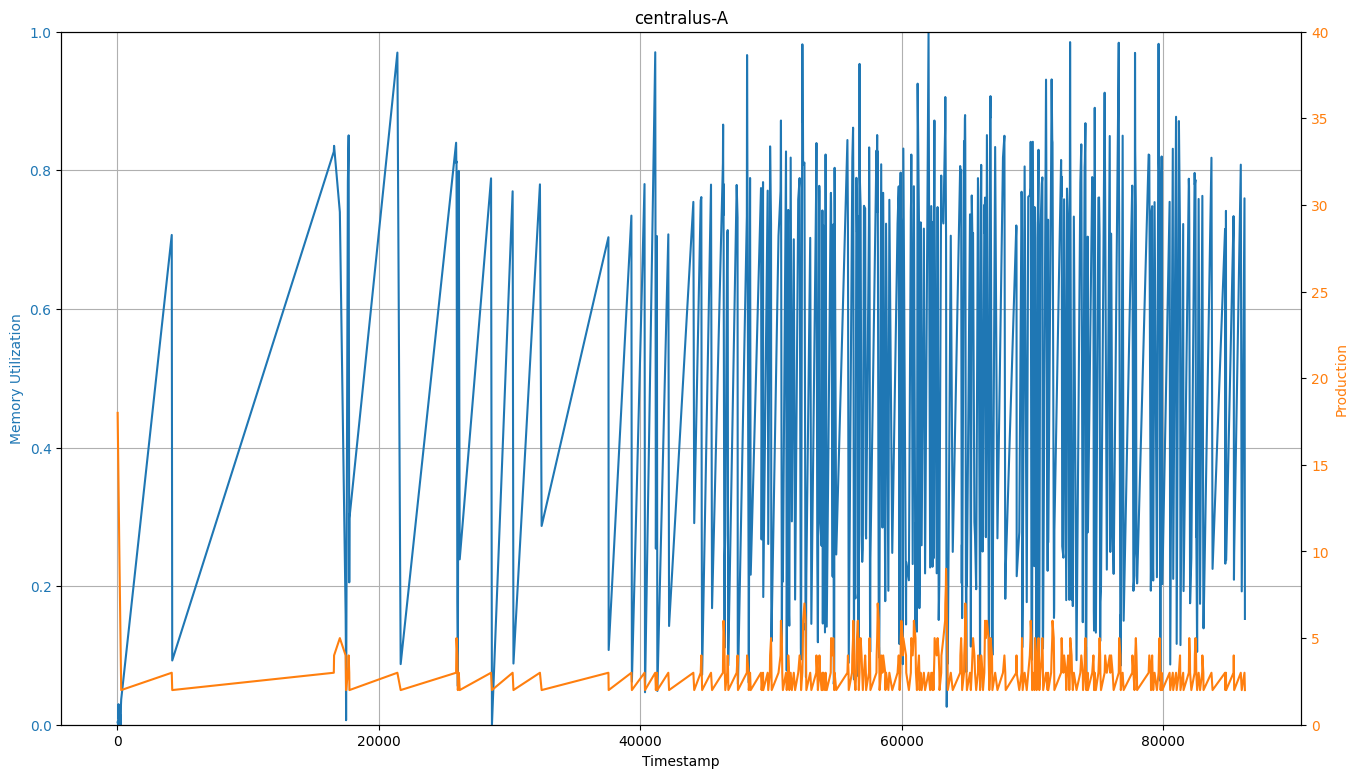

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

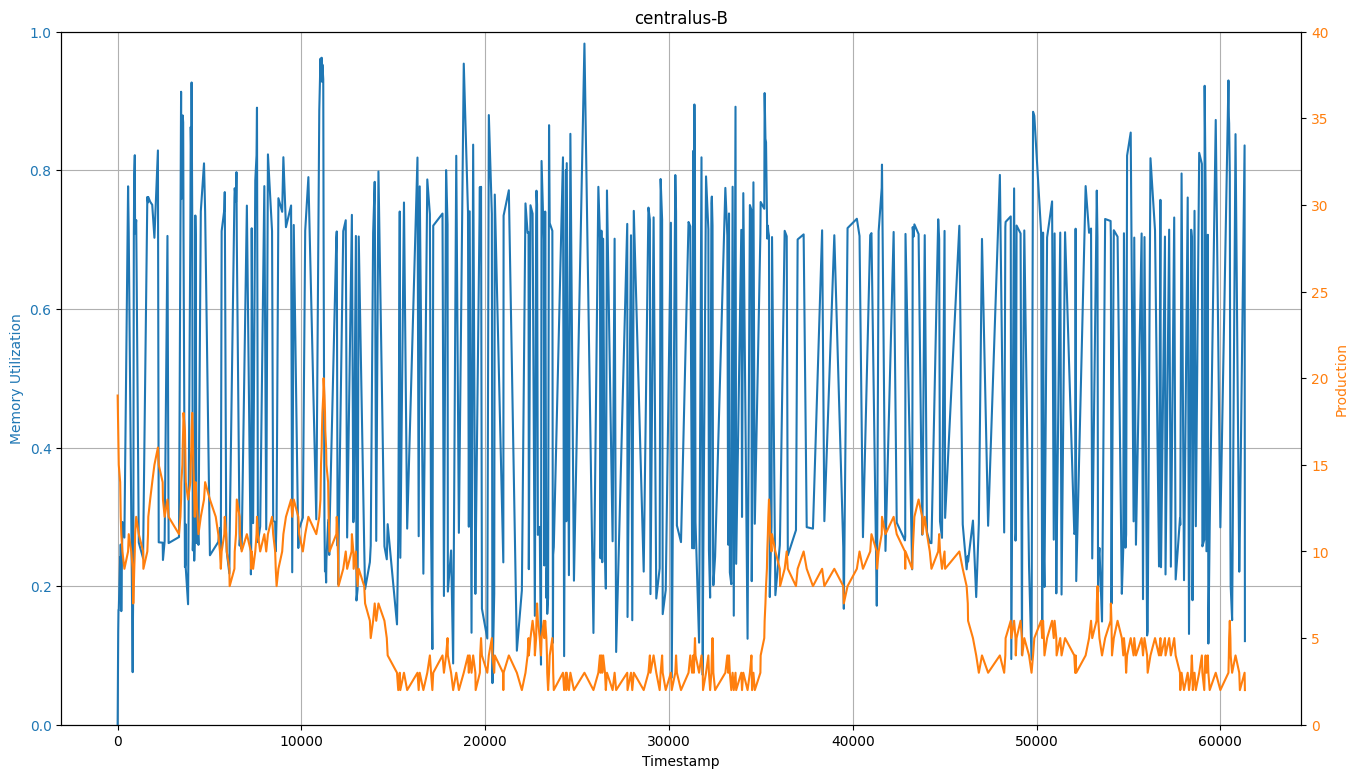

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

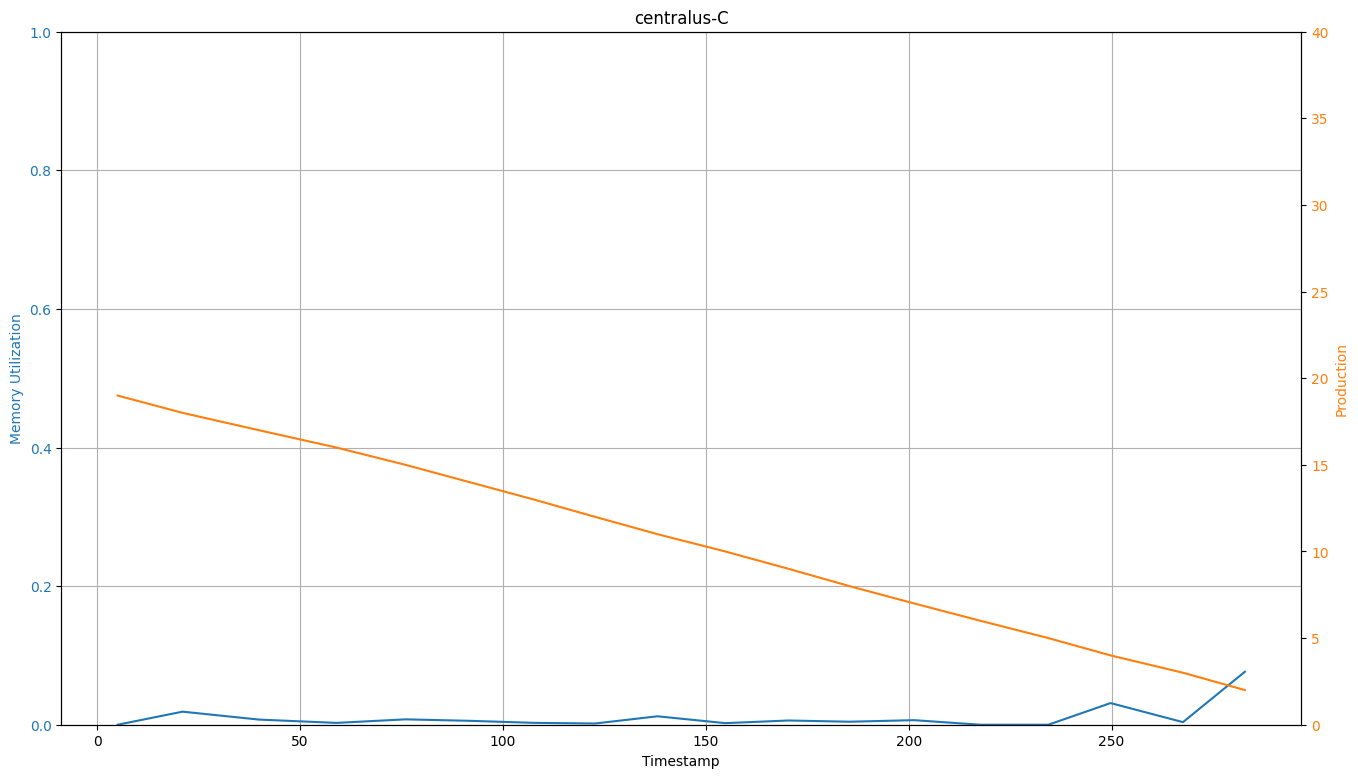

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

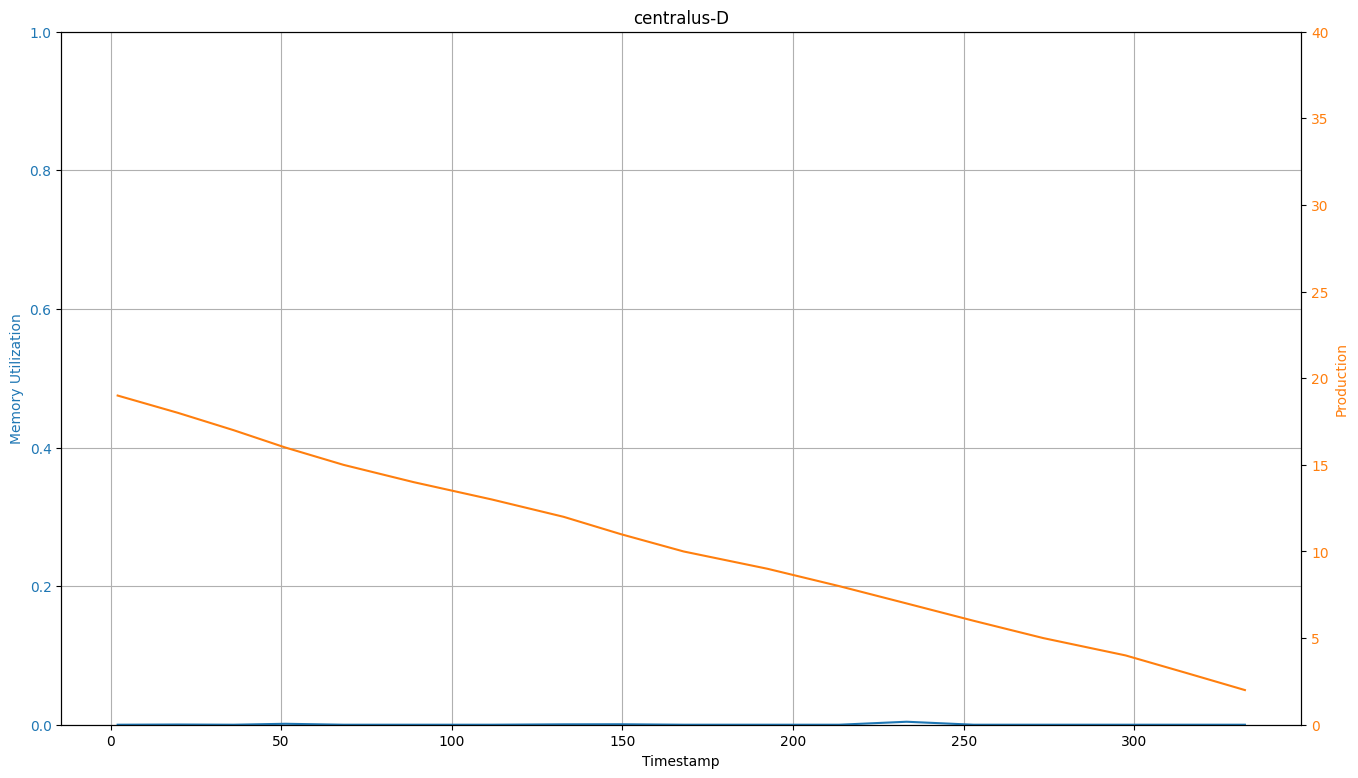

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

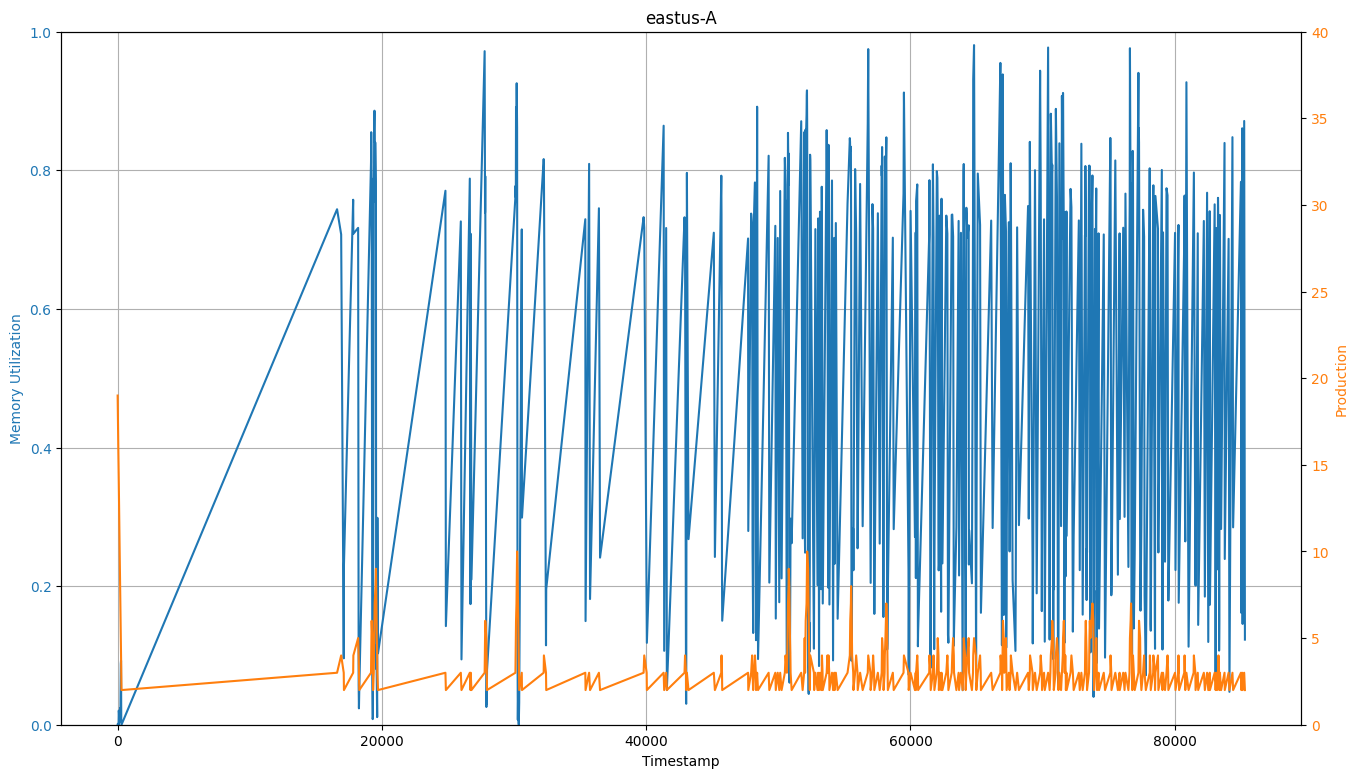

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

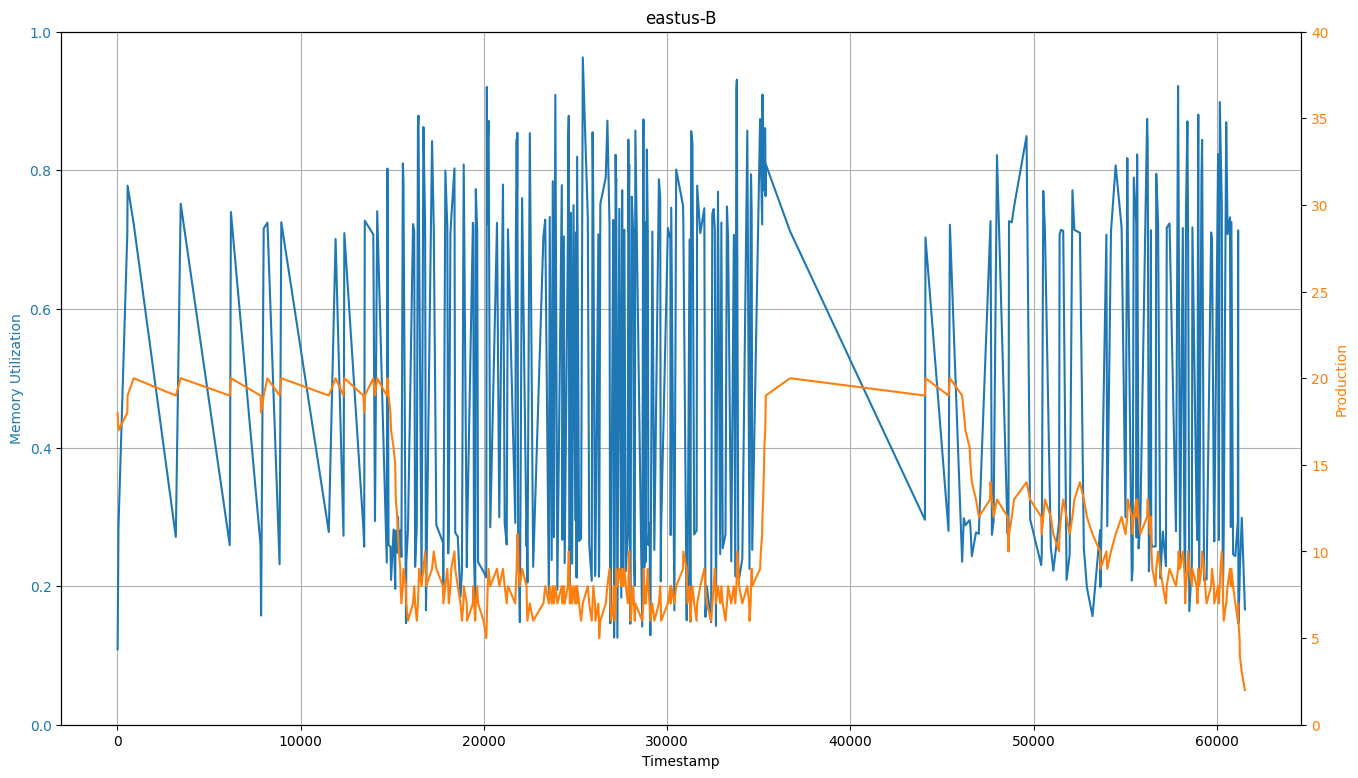

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

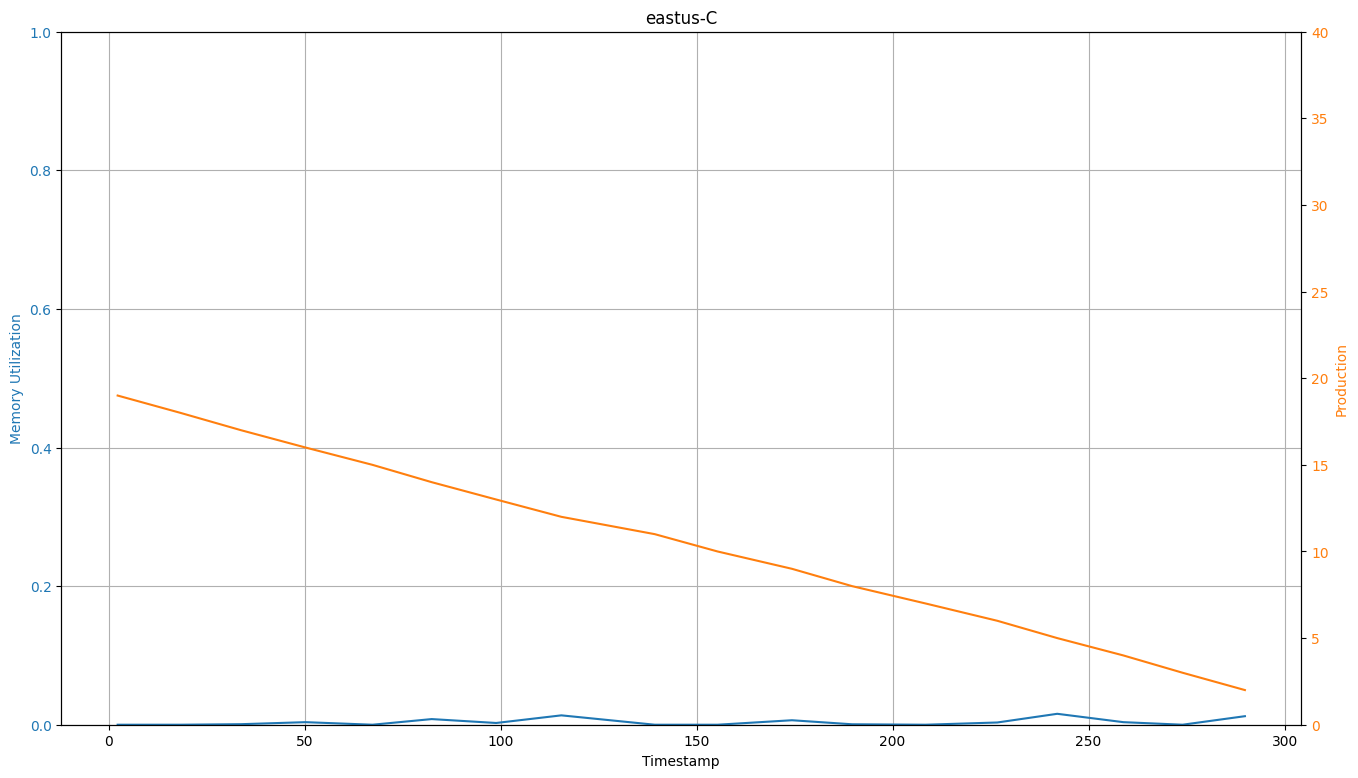

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_5926/1805686450.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values


<Figure size 1600x900 with 0 Axes>

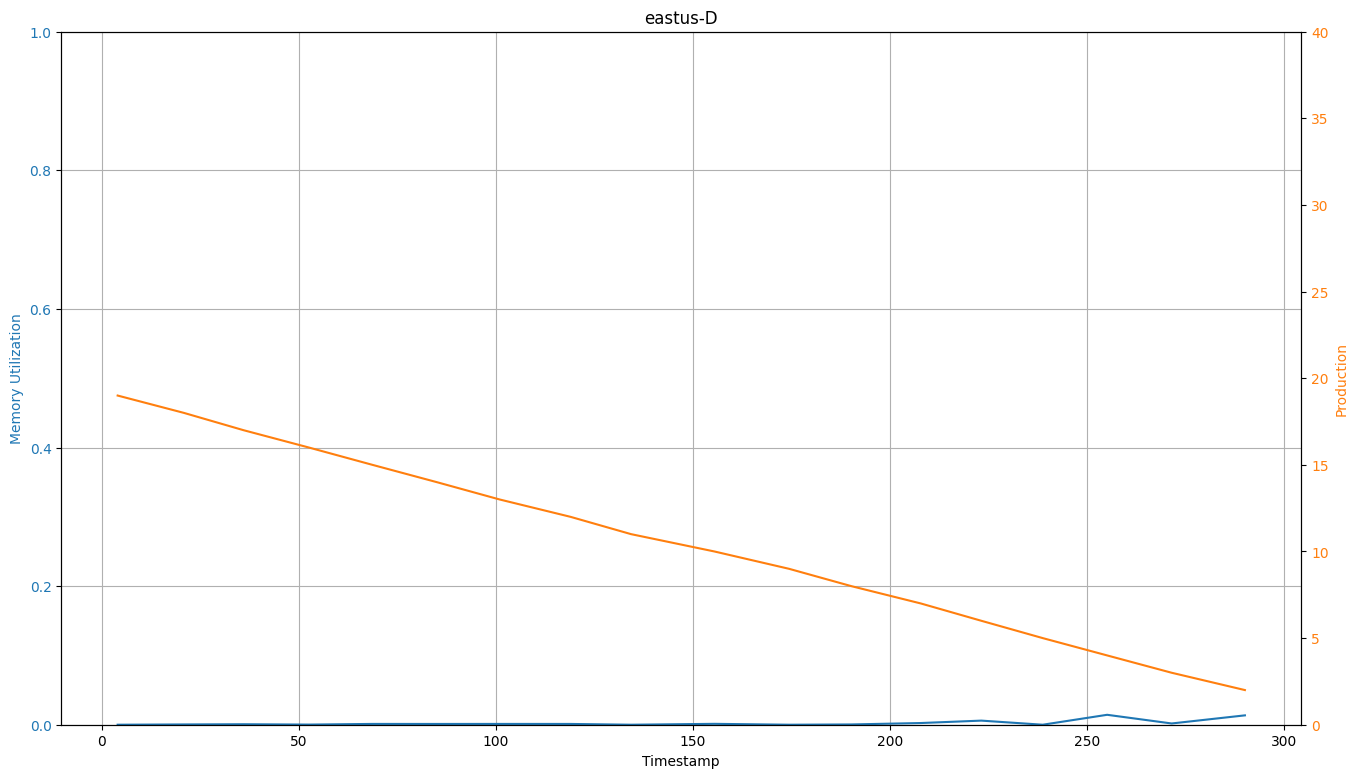

In [54]:
# state of deployment
arbiter_log_dir = os.path.join(get_output_dir(), "arbiters")
regions = ["westus", "centralus", "eastus"]
models = ["A", "B", "C", "D"]

for region in regions:
    df = get_merged_df(os.path.join(arbiter_log_dir, f"{region}"))
    for model in models:
        plt.figure(figsize=(16, 9), dpi=100)
        
        dfm = df[df['model'] == model]
        dfm['prod_diff'] = dfm['prod'].diff()  # Calculate the difference between consecutive 'prod' values
        filtered_df = dfm[abs(dfm['prod_diff']) > 0]
        dfm = filtered_df.sort_values(by='timestamp')
        
        # Create the plot for memory_util (right y-axis)
        fig, ax1 = plt.subplots(figsize=(16, 9), dpi=100)
        
        ax1.plot(dfm['timestamp'], dfm['memory_util'], color='tab:blue', label='memory_util')
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel('Memory Utilization', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        
        # Create a second y-axis for prod
        ax2 = ax1.twinx()
        ax2.plot(dfm['timestamp'], dfm['prod'], color='tab:orange', label='prod')
        ax2.set_ylabel('Production', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        ax2.set_ylim(0, 40)
        ax1.set_ylim(0, 1)
        plt.title(f"{region}-{model}")
        ax1.grid()
        plt.show()

index     timestamp model  prod  spot  memory_util  prod_diff
1            1      1.035194     B    39     1     0.000000       -1.0
2            2      1.035194     C    40     0     0.000000        1.0
5            5      1.339970     B    38     2     0.000044       -2.0
6            6      1.339970     C    40     0     0.000044        2.0
9            9      1.353532     B    37     3     0.000176       -3.0
...        ...           ...   ...   ...   ...          ...        ...
2095869  28857  86006.810710     B     2    38     0.005354       -1.0
2095872  28860  86006.836657     A     3    37     0.009454        1.0
2095873  28861  86006.836657     B     2    38     0.009454       -1.0
2095876  28864  86007.054972     A     3    37     0.044577        1.0
2095877  28865  86007.054972     B     2    38     0.044577       -1.0

[194142 rows x 7 columns]

In [13]:
# state of deployment
arbiter_log_dir = os.path.join(get_output_dir(), "arbiters")
regions = ["westus", "centralus", "eastus"]
for region in regions:
    df = get_merged_df(os.path.join(arbiter_log_dir, f"{region}"))
    plt.figure(figsize=(16,9), dpi=100)
    models = df['model'].unique()
    base = 0
    mdf1 = df[df['model'] == models[0]]
    # mdf1 = mdf1.set_index('timestamp')
    mdf2 = df[df['model'] == models[1]]
    # mdf2 = mdf2.set_index('timestamp')
    res = pd.concat([mdf1.reset_index().add_suffix(f'_{models[0]}'), mdf2.reset_index().add_suffix(f'_{models[1]}')], axis=1)

    # print(result)
    plt.fill_between(res[f'timestamp_{models[0]}'], 0,  res['prod_bloom-176b'], label=f"{models[0]}-prod", alpha=0.8, color='red')
    plt.fill_between(res[f'timestamp_{models[0]}'],  res['prod_bloom-176b'], res['prod_bloom-176b']+res['spot_bloom-176b'], label=f"{models[0]}-spot", alpha=0.5, color='red')

    plt.fill_between(res[f'timestamp_{models[0]}'], res['spot_bloom-176b']+res['prod_bloom-176b'],  res['spot_bloom-176b']+res['prod_bloom-176b']+res['prod_llama2-70b'], label=f"{models[1]}-prod", alpha=0.8, color='blue')
    plt.fill_between(res[f'timestamp_{models[0]}'],  res['spot_bloom-176b']+res['prod_bloom-176b']+res['prod_llama2-70b'], res['spot_bloom-176b']+res['prod_bloom-176b']+res['prod_llama2-70b']+res['spot_llama2-70b'], label=f"{models[1]}-spot", alpha=0.5, color='blue')
    plt.title(region)
    plt.legend()
    plt.show()

KeyError: 'prod_bloom-176b'

<Figure size 1600x900 with 0 Axes>

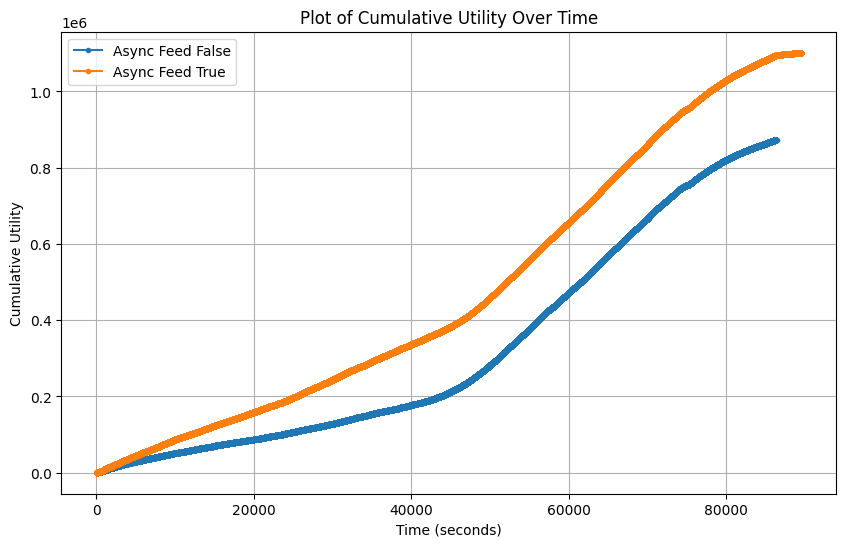

In [68]:
#utility timeline
import pandas as pd
import matplotlib.pyplot as plt
out_dirs = [(get_output_dir(feed_async=False), False), (get_output_dir(), True)]
plt.figure(figsize=(10, 6))
for out_dir, async_feed in out_dirs:
    gr_csv_path = os.path.join(out_dir, "global_router.csv")
    df = pd.read_csv(gr_csv_path)
    df1 = df.sort_values(by="completion_time")

    # Compute the cumulative sum of the numeric column
    df1['cumulative_sum'] = df1['utility'].cumsum()

    # Plot the cumulative sum against time
    plt.plot(df1['completion_time'], df1['cumulative_sum'], marker='.', label=f'Async Feed {async_feed}')
plt.xlabel("Time (seconds)")
plt.ylabel("Cumulative Utility")
plt.title("Plot of Cumulative Utility Over Time")
plt.legend()
plt.grid(True)
# add vertical line at x = 50k
plt.show()


/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_71010/2768007746.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


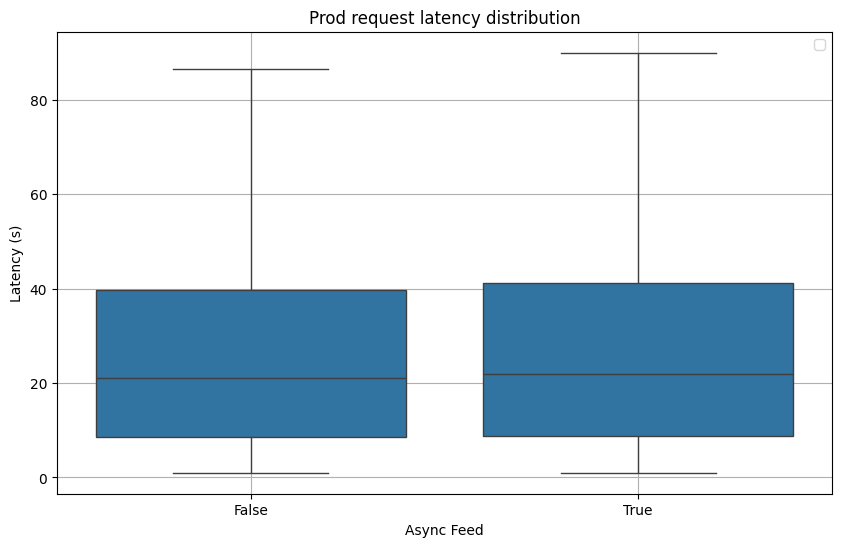

In [73]:
#utility timeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
out_dirs = [(get_output_dir(feed_async=False), False), (get_output_dir(), True)]
plt.figure(figsize=(10, 6))
dfa = {
    'latency': [],
    'async_feed': []
}
# TODO: per model
for out_dir, async_feed in out_dirs:
    gr_csv_path = os.path.join(out_dir, "global_router.csv")
    df = pd.read_csv(gr_csv_path)
    df = df[df['workload_type'] == 'prod']
    dfa['latency'].extend(list(df['response_time']))
    dfa['async_feed'].extend([async_feed] * len(df))

    # Plot the cumulative sum against time
df1 = pd.DataFrame(dfa)
sns.boxplot(data=df1, x='async_feed', y='latency', showfliers=False)
plt.xlabel("Async Feed")
plt.ylabel("Latency (s)")
plt.title("Prod request latency distribution")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#dollar cost
# 1*input*c1 + 3*output*c2 + gpu-hours * c
# 

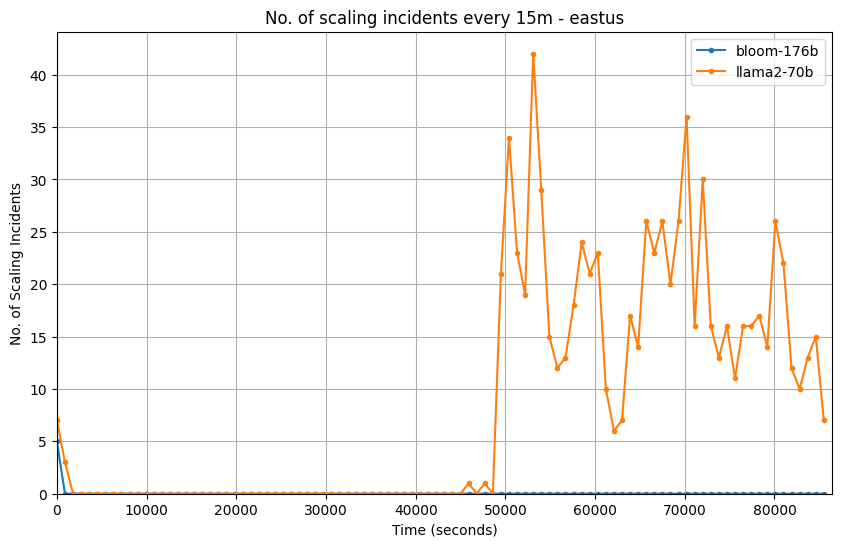

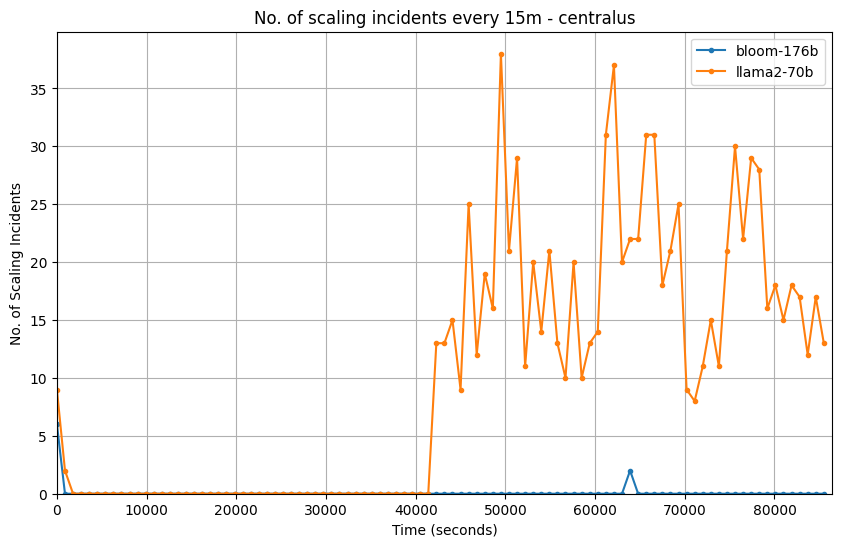

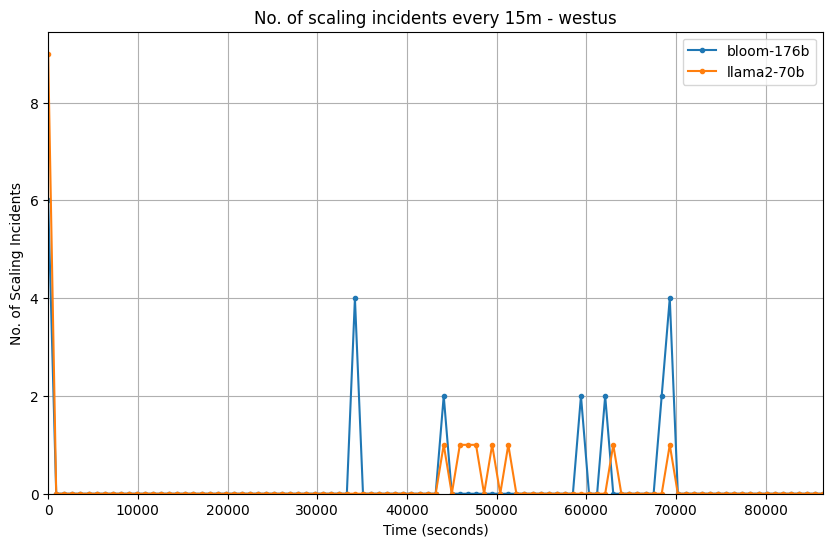

In [102]:
# scaling overhead
import pandas as pd
import matplotlib.pyplot as plt
arbiter_log_dir = os.path.join(get_output_dir(), "arbiters")

for region in ['eastus', 'centralus', 'westus']:
    csv_path = os.path.join(arbiter_log_dir, f"{region}.csv")

    # Step 1: Read the CSV file
    dfo = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))

    for model in dfo['model'].unique():

        df = dfo[dfo['model'] == model]

        df = df.drop(columns=['model'])

        # Step 3: Order the table by 'timestamp'
        df = df.sort_values('timestamp').reset_index(drop=True)

        # Define your custom function f
        def f(spot_i, prod_i, spot_next, prod_next):
            # Replace this with your actual function logic
            if prod_i + spot_i == prod_next + spot_next:
                return abs(prod_i - prod_next)
            else:
                return abs(prod_i - prod_next)

        # Step 4: Compute the difference between consecutive rows
        # Shift the columns to get the next row's values
        df['spot_next'] = df['spot'].shift(-1)
        df['prod_next'] = df['prod'].shift(-1)
        df['timestamp_next'] = df['timestamp'].shift(-1)

        # Apply the function to each row
        df['f_value'] = df.apply(
            lambda row: f(row['spot'], row['prod'], row['spot_next'], row['prod_next']),
            axis=1
        )

        # Remove the last row as it will have NaN values after shifting
        df = df.iloc[:-1]

        # Step 5: Create 900-second (15-minute) time buckets
        df['time_bucket'] = (df['timestamp'] // 900).astype(int) * 900

        # Step 6: Sum the 'f_value' over each time bucket
        bucket_sums = df.groupby('time_bucket')['f_value'].sum().reset_index()

        # Step 7: Plot the results
        
        plt.plot(bucket_sums['time_bucket'], bucket_sums['f_value'], marker='.', label=model)
    plt.xlabel('Time (seconds)')
    plt.ylabel('No. of Scaling Incidents')
    plt.title('No. of scaling incidents every 15m - '+ region)
    plt.xlim(0, 86400)
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()


../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_bloom-176b_1.csv


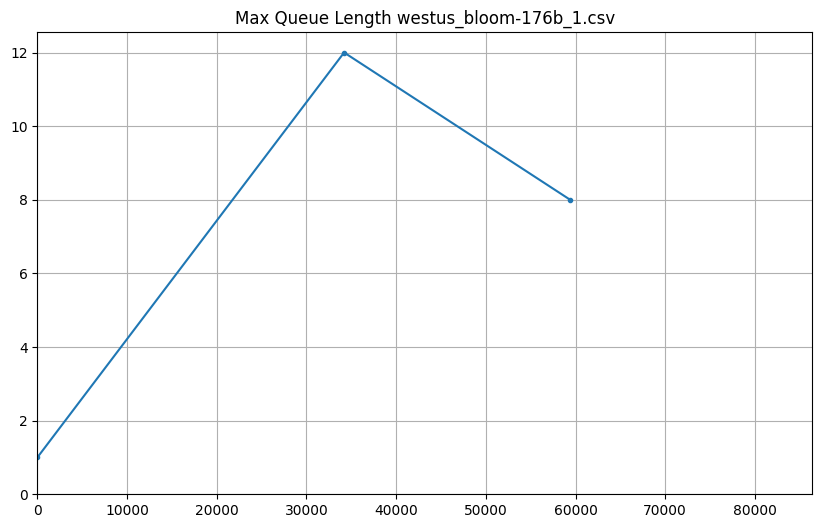

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_bloom-176b_2.csv


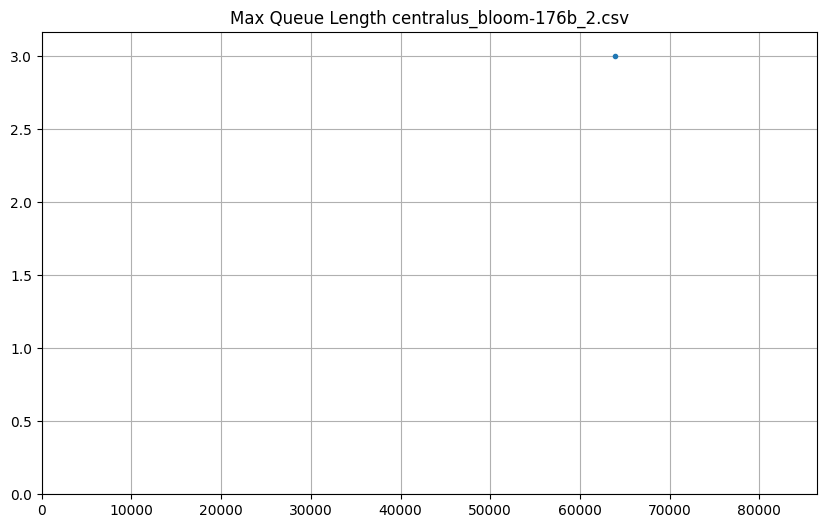

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_bloom-176b_0.csv


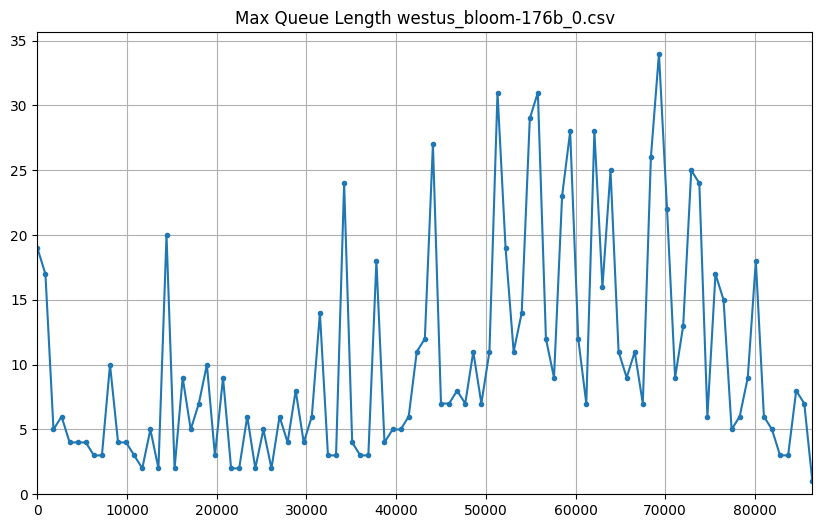

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_bloom-176b_2.csv


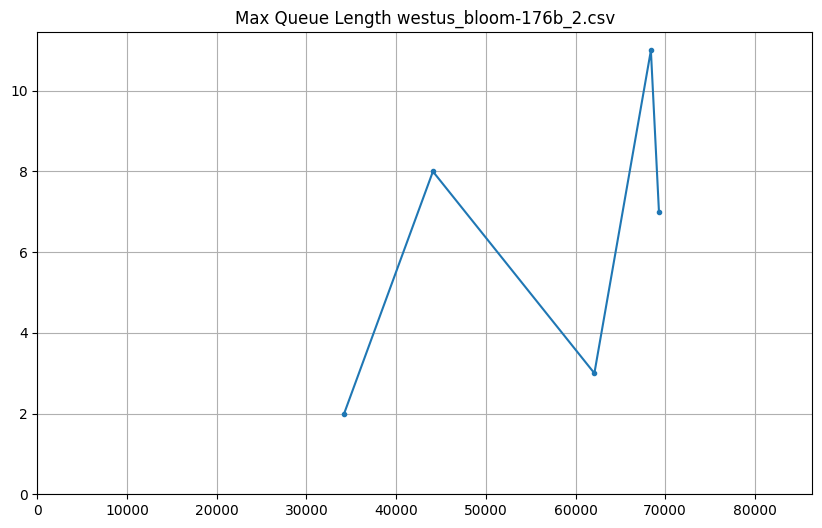

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_bloom-176b_0.csv


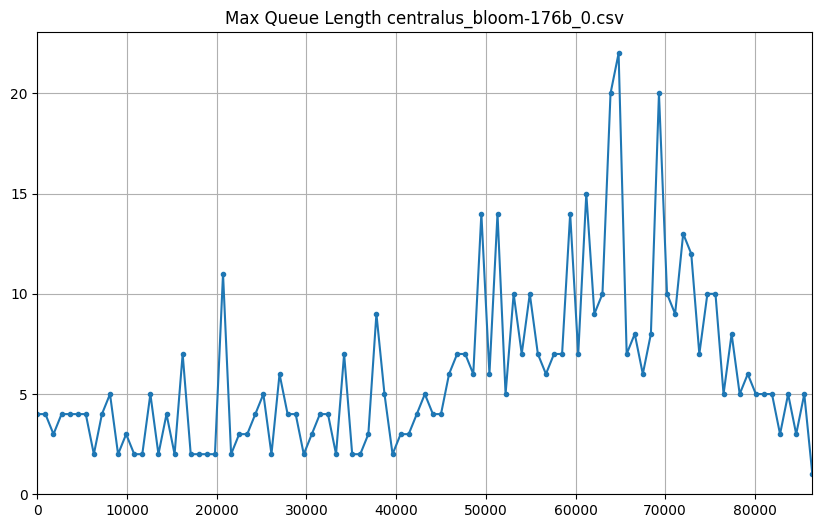

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_bloom-176b_1.csv


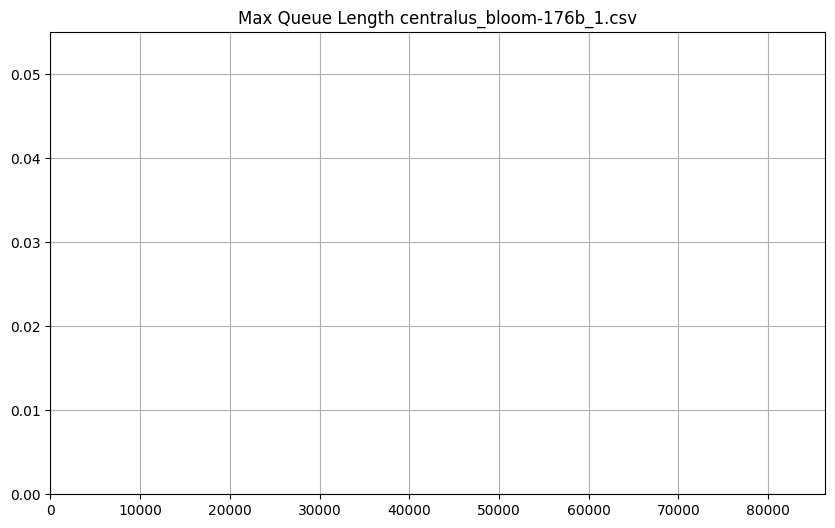

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_llama2-70b_1.csv


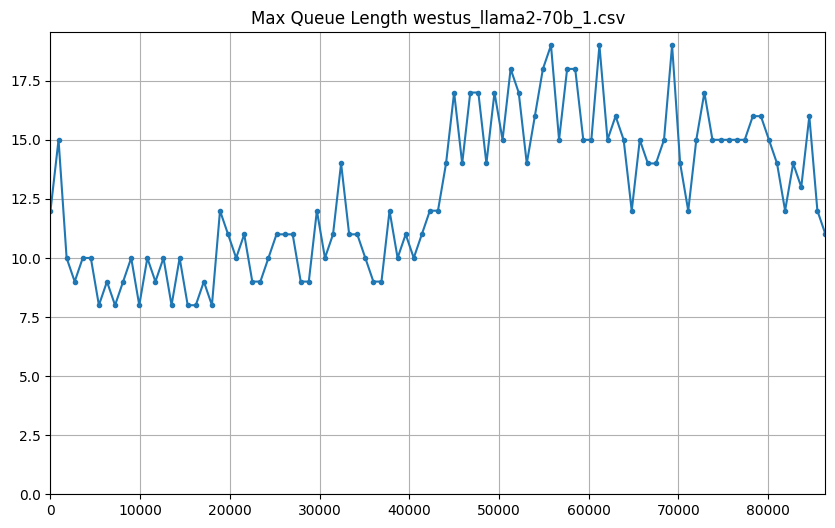

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_llama2-70b_3.csv


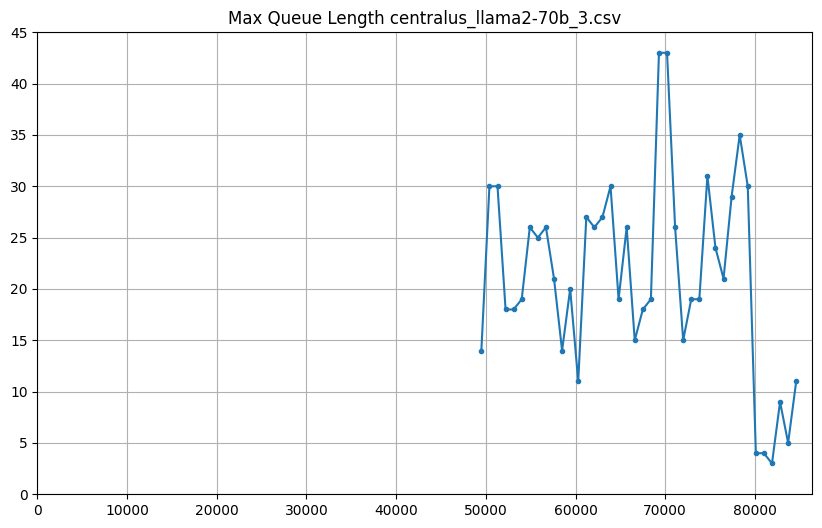

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_llama2-70b_2.csv


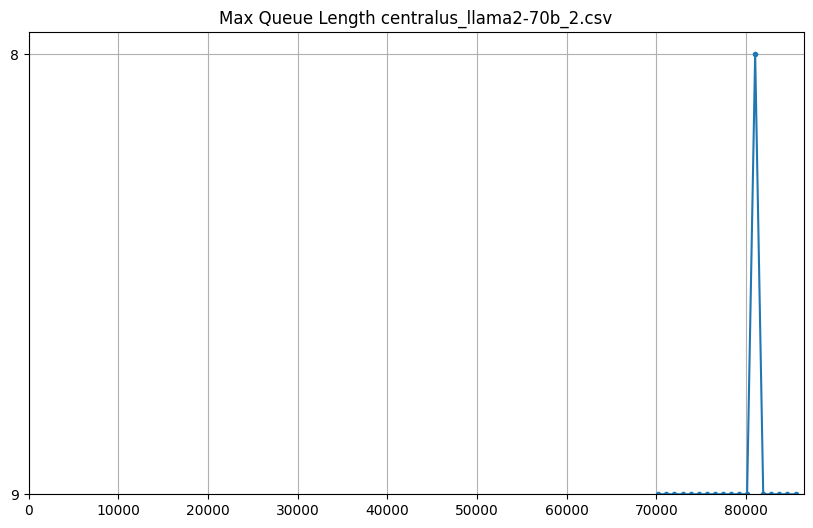

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_llama2-70b_0.csv


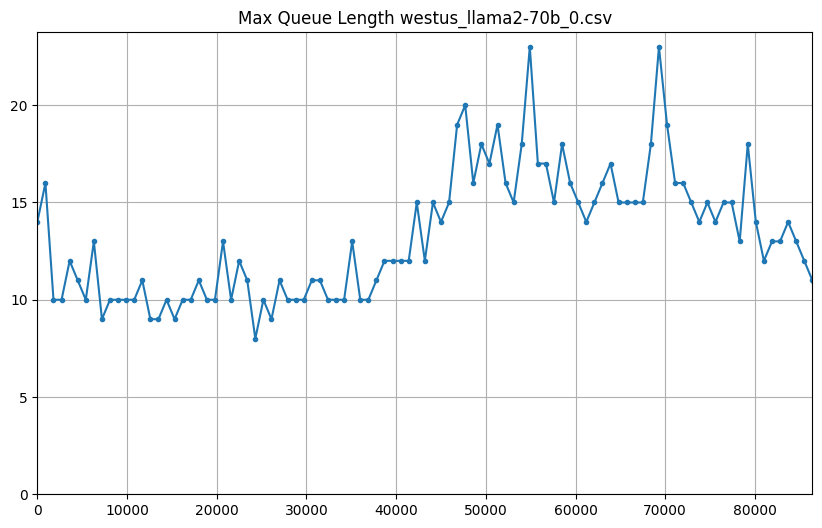

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_llama2-70b_2.csv


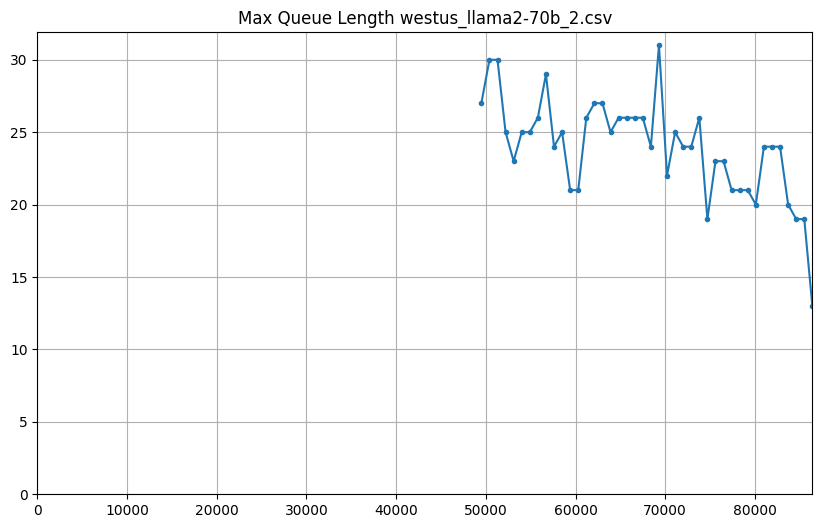

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_llama2-70b_0.csv


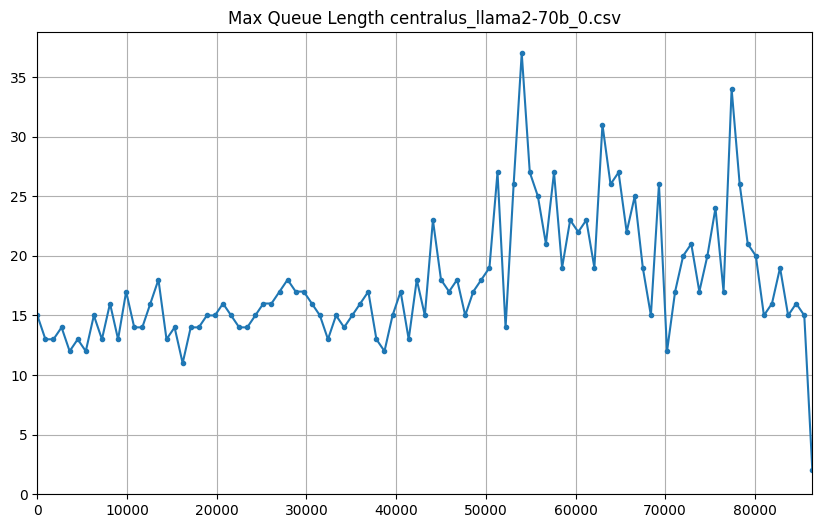

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/centralus_llama2-70b_1.csv


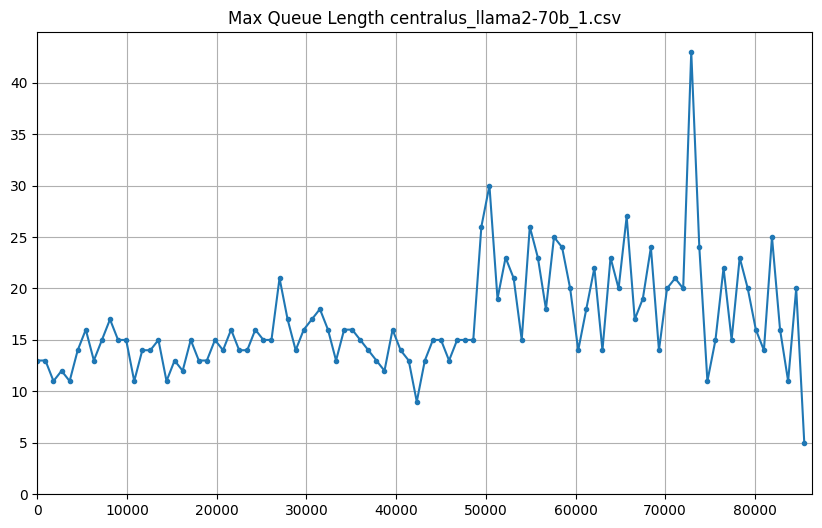

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_llama2-70b_3.csv


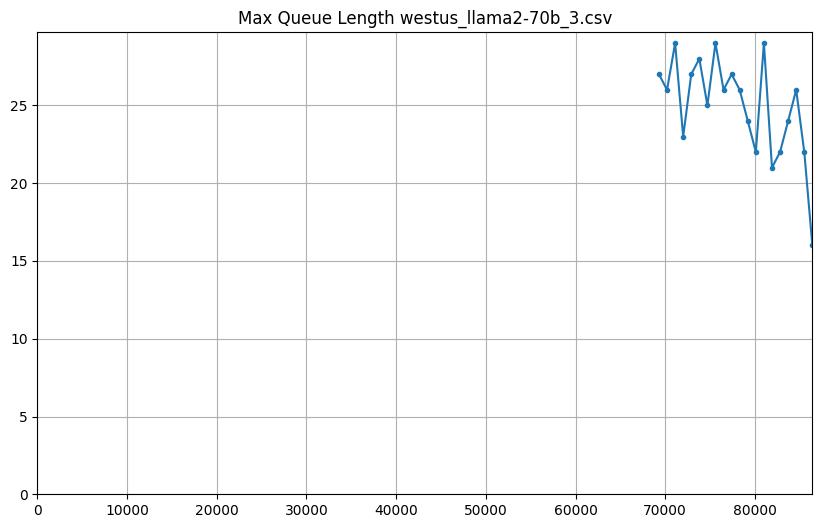

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/westus_llama2-70b_4.csv


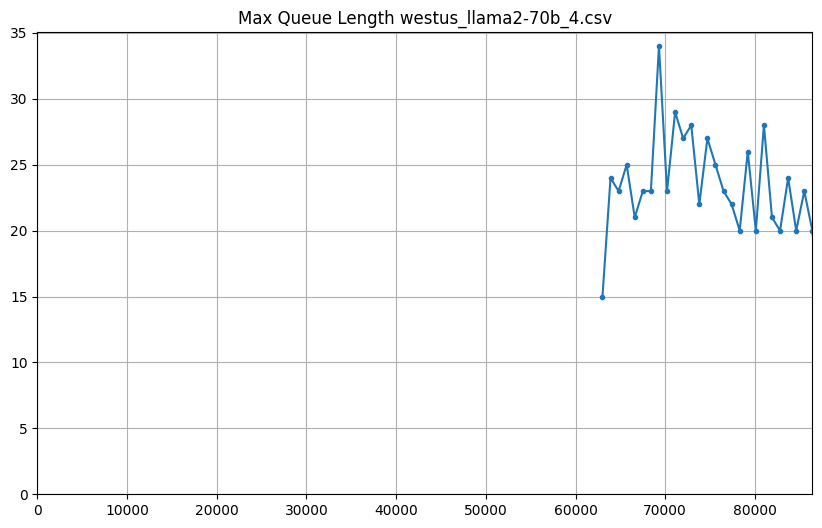

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_llama2-70b_0.csv


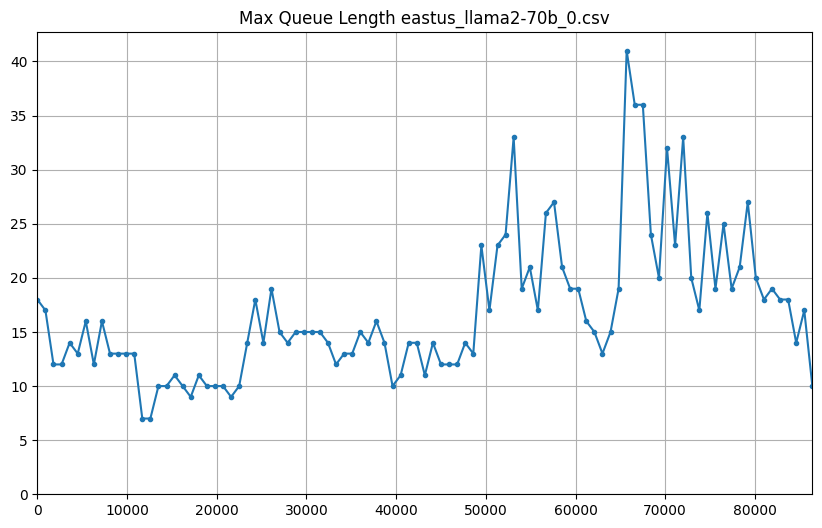

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_llama2-70b_1.csv


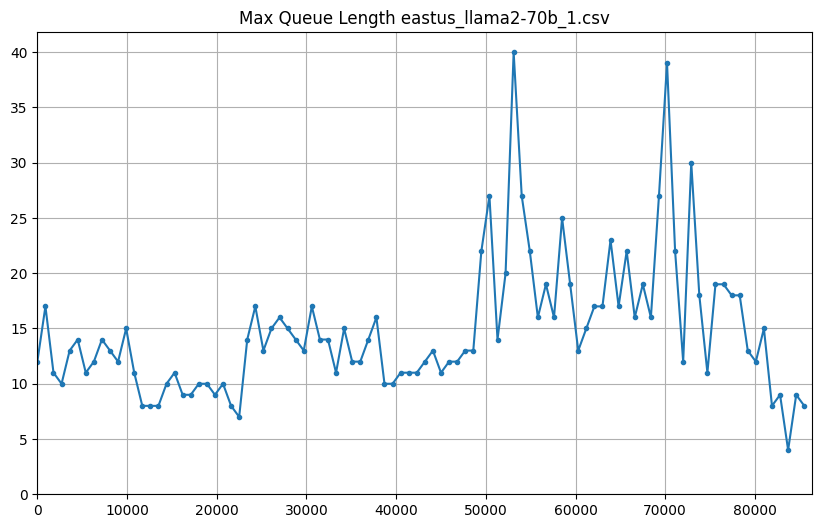

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_llama2-70b_3.csv


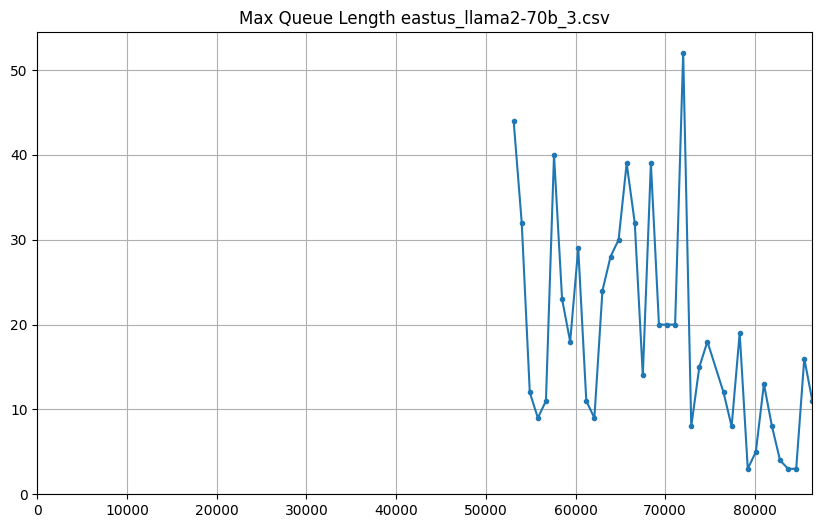

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_llama2-70b_2.csv


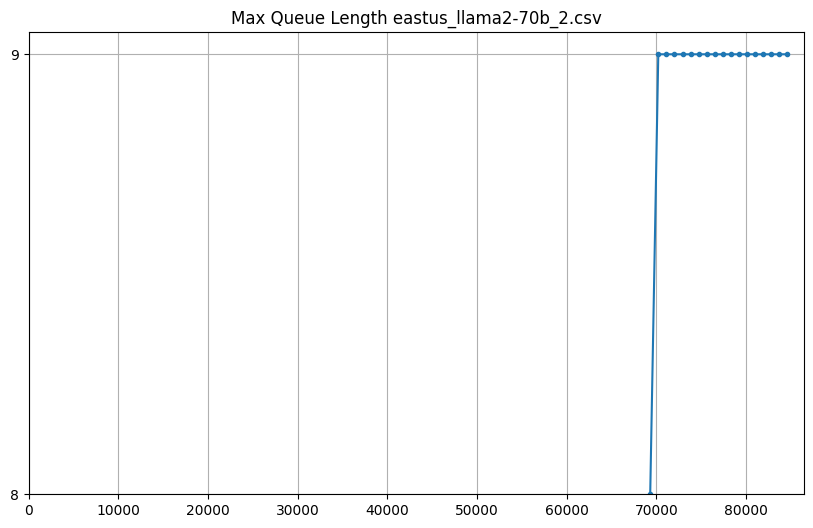

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_bloom-176b_0.csv


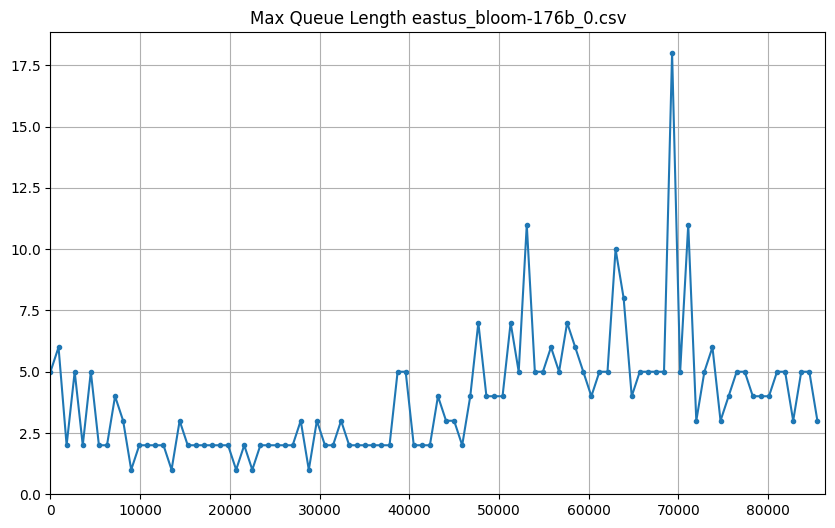

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_bloom-176b_1.csv


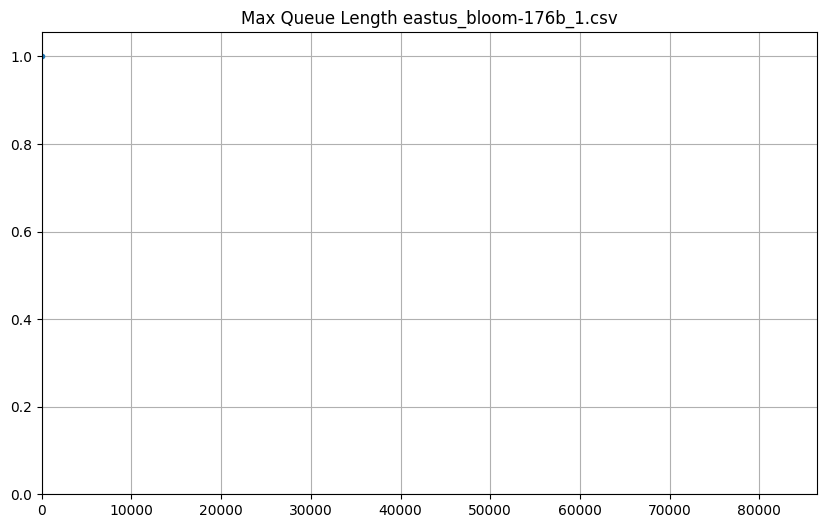

../results/0/ES_26/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/instances/eastus_bloom-176b_2.csv


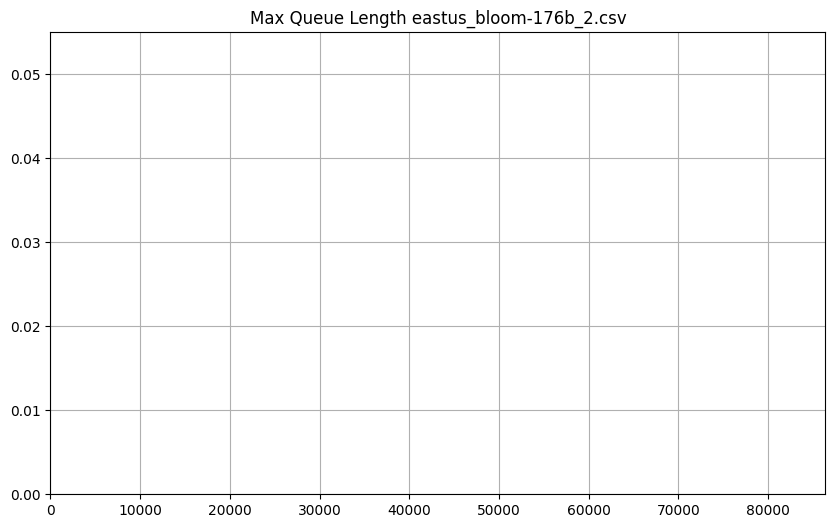

In [101]:
#queue length
import os
import pandas as pd
import matplotlib.pyplot as plt

instance_log_dir = os.path.join(get_output_dir(), "instances")

for app_file in os.listdir(instance_log_dir):
    
    app_file_path = os.path.join(instance_log_dir, app_file)
    df = pd.read_csv(app_file_path)
    print(app_file_path)

    df['iteration_end'] = pd.to_numeric(df['iteration_end'], errors='coerce')
    
    cols_to_check = [col for col in df.columns if col != 'tag']

    # Step 3: Drop rows where any of the other columns have NaN values
    df = df.dropna(subset=cols_to_check)
    df['time_bucket'] = (df['iteration_end'] // 900).astype(int) * 900

    # Step 6: Sum the 'f_value' over each time bucket
    bucket_sums = df.groupby('time_bucket')['pending_requests'].max().reset_index()

    # Step 7: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(bucket_sums['time_bucket'], bucket_sums['pending_requests'], marker='.')
    plt.xlim(0, 86400)
    plt.ylim(bottom=0)
    plt.grid()
    plt.title("Max Queue Length " + app_file)
    plt.show()

